In [1]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import CSVLogger
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from collections import deque
import copy

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

BATCH_SIZE = 256 
EPOCHS = 40
NUMBER_TEST_SET = 72000 #will do train/test split before this, and pass already-made sets in
TEMPORAL_LENGTH = 8 #use first 8 frames (these are 16 frames in each video)

2022-05-08 14:19:12.598650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:19:12.691586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:19:12.692983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def file_generator(data_path,data_files,temporal_stride=1,temporal_length=TEMPORAL_LENGTH):
    #print(data_files)
    for f in data_files: 
        tmp_df = pd.read_csv(os.path.join(data_path,f), sep=',')
        label_list = list(tmp_df['label'])  
        total_images = len(label_list) 
        if total_images==temporal_length: 
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            #print ('num of frames: {}: {}'.format(f,num_samples))
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames < than temporal length , discard it
            print ('num of frames is less than temporal length; hence discarding this file-{}'.format(f))
            continue

        start_frame = 0
        samples = deque()  
        samp_count=0  
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: 
                samples_c=copy.deepcopy(samples) 
                samp_count+=1
                for t in range(temporal_stride): 
                    samples.popleft()
                yield samples_c,label_list[0]  

In [3]:
def load_samples(data_cat='train',temporal_stride=1,temporal_length=TEMPORAL_LENGTH):
    data_path = os.path.join('/uscms_data/d3/jieun201/YOURWORKINGAREA/data_files',data_cat)
    data_files = os.listdir(data_path)
    #generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            #print(x)
            data_list.append([x,y])
        except Exception as e:
            print ('Exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

In [4]:
train_data = load_samples(data_cat='train',temporal_stride=1,temporal_length=TEMPORAL_LENGTH)

Exception:  
end of data generator


In [5]:
print(os.path.join('/uscms_data/d3/jieun201/YOURWORKINGAREA/data_files','train'))

/uscms_data/d3/jieun201/YOURWORKINGAREA/data_files/train


In [6]:
test_data = load_samples(data_cat='test',temporal_stride=1,temporal_length=TEMPORAL_LENGTH)

Exception:  
end of data generator


In [7]:
print ('Total number of train samples:',len(train_data))

Total number of train samples: 288000


In [8]:
train_data[0]

[['/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame00.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame01.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame02.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame03.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame04.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame05.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame06.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures/d16111cluster0/event000000_frame07.npy'],
 -0.1132745164574143]

In [9]:
print ('Total number of test samples:',len(test_data))

Total number of test samples: 72000


In [10]:
test_data[0]

[['/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame00.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame01.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame02.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame03.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame04.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame05.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame06.npy',
  '/uscms_data/d3/jieun201/YOURWORKINGAREA/figures-test/cluster0/event000000_frame07.npy'],
 0.0806657911875553]

In [11]:
def shuffle_data(samples):
    data = shuffle(samples,random_state=2)
    return data

In [12]:
def data_generator(data,batch_size=BATCH_SIZE,temporal_padding='same',shuffle=True):               
    num_samples = len(data)
    if shuffle:
        data = shuffle_data(data)
    while True:   
        for offset in range(0, num_samples, batch_size):
            #print ('starting index: ', offset) 
            batch_samples = data[offset:offset+batch_size]
            
            X_train = []
            y_train = []
            
            for batch_sample in batch_samples: 
                #print(batch_sample)
                # Load image (X)
                x = batch_sample[0] #image
                y = batch_sample[1] #label
                temp_data_list = []
                for img in x:
                    try:
                        img = np.load(img)                        
                        temp_data_list.append(img)
                    except Exception as e:
                        print (e)
                        print ('error reading in frame: ',img)                      

                X_train.append(temp_data_list)
                y_train.append(y)

            X_train = np.array(X_train)   
            y_train = np.array(y_train)
            
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        
            print(X_train.shape)               
            yield X_train, y_train

In [18]:
#print(len(train_data))
#print(len(test_data))

train_generator = data_generator(train_data,batch_size=BATCH_SIZE,shuffle=True)

test_generator = data_generator(test_data,batch_size=BATCH_SIZE,shuffle=False) 
#x,y = next(train_generator)
#xx,yy = next(train_generator)

In [19]:
def get_model():
    model = Sequential()
    model.add(
    TimeDistributed(
        Conv2D(16, (3,3), activation='relu'), 
        input_shape=(8, 13, 21, 1))
    )
    model.add(
    TimeDistributed(
        Conv2D(32, (3,3), activation='relu')
        )
    )
    model.add(
    TimeDistributed(
        MaxPooling2D()
        )
    ) 
          
    model.add(
    TimeDistributed(
        Flatten()
        )
    )        
    model.add(LSTM(64, activation='relu', return_sequences=False, recurrent_dropout=0.5))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='Huber', optimizer=Adam(), metrics=['mean_squared_error'])
    model.summary()
    return model

model = get_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 8, 11, 19, 16)    160       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 8, 9, 17, 32)     4640      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 8, 4, 8, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 8, 1024)          0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 64)               

In [20]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))    

In [21]:
checkpoint_path = "cp.ckpt"
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)
csv_logger = CSVLogger('log.csv', append=True, separator=';')

In [22]:
#rom keras.models import load_model
#model = tf.keras.models.load_model('./cp.ckpt/')

hist = model.fit(train_generator,
                 steps_per_epoch=(len(train_data)/BATCH_SIZE),
                 epochs=EPOCHS,
                 validation_data=(test_generator), validation_steps=(len(test_data)/BATCH_SIZE),
                 use_multiprocessing=True,workers=6,
                 callbacks=[cp_callback, csv_logger, earlyStop_callback])

(256, 8, 13, 21)
Epoch 1/40


2022-05-08 15:54:48.374387: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-05-08 15:54:49.746399: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-05-08 15:54:49.839425: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


   6/1125 [..............................] - ETA: 1:29 - loss: 0.0196 - mean_squared_error: 0.0398(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)





  12/1125 [..............................] - ETA: 8:16 - loss: 0.0139 - mean_squared_error: 0.0281(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)



  18/1125 [..............................] - ETA: 20:45 - loss: 0.0114 - mean_squared_error: 0.0229(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)




  24/1125 [..............................] - ETA: 26:47 - loss: 0.0097 - mean_squared_error: 0.0195(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)





  30/1125 [..............................] - ETA: 30:38 - loss: 0.0086 - mean_squared_error: 0.0173(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


2022-05-08 16:44:41.003468: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
INFO:tensorflow:Assets written to: cp.ckpt/assets
(256, 8, 13, 21)


1125/1125 [==============================] - 3003s 3s/step - loss: 0.0011 - mean_squared_error: 0.0023 - val_loss: 5.6760e-04 - val_mean_squared_error: 0.0011
Epoch 2/40
  11/1125 [..............................] - ETA: 1:42 - loss: 4.6184e-04 - mean_squared_error: 9.2368e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  15/1125 [..............................] - ETA: 4:59 - loss: 4.7134e-04 - mean_squared_error: 9.4267e-04(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)
  21/1125 [..............................] - ETA: 11:34 - loss: 4.9891e-04 - mean_squared_error: 9.9782e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)





  27/1125 [..............................] - ETA: 21:55 - loss: 5.1347e-04 - mean_squared_error: 0.0010(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)





  33/1125 [..............................] - ETA: 28:55 - loss: 5.1244e-04 - mean_sq

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 2823s 3s/step - loss: 4.0732e-04 - mean_squared_error: 8.1465e-04 - val_loss: 3.7908e-04 - val_mean_squared_error: 7.5817e-04
Epoch 3/40
  12/1125 [..............................] - ETA: 5:52 - loss: 3.0124e-04 - mean_squared_error: 6.0247e-04(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)

(256, 8, 13, 21)
  18/1125 [..............................] - ETA: 13:39 - loss: 3.1271e-04 - mean_squared_error: 6.2542e-04(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)


(256, 8, 13, 21)
  24/1125 [..............................] - ETA: 20:06 - loss: 3.1137e-04 - mean_squared_error: 6.2275e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)

  30/1125 [..............................] - ETA: 23:56 - loss: 2.9528e-04 - mean_squared_error: 5.9056e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)




INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 2662s 2s/step - loss: 3.2201e-04 - mean_squared_error: 6.4401e-04 - val_loss: 3.5155e-04 - val_mean_squared_error: 7.0309e-04
Epoch 4/40
  11/1125 [..............................] - ETA: 1:37 - loss: 2.8603e-04 - mean_squared_error: 5.7206e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  15/1125 [..............................] - ETA: 4:32 - loss: 2.6818e-04 - mean_squared_error: 5.3636e-04(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)

  21/1125 [..............................] - ETA: 14:49 - loss: 3.0155e-04 - mean_squared_error: 6.0311e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)

  27/1125 [..............................] - ETA: 19:07 - loss: 2.8678e-04 - mean_squared_error: 5.7356e-04(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)
  33/1125 [..............................] - ETA: 22

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 2645s 2s/step - loss: 2.7226e-04 - mean_squared_error: 5.4451e-04 - val_loss: 3.3459e-04 - val_mean_squared_error: 6.6918e-04
Epoch 5/40
  12/1125 [..............................] - ETA: 5:28 - loss: 2.3152e-04 - mean_squared_error: 4.6304e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)
  18/1125 [..............................] - ETA: 13:00 - loss: 2.5707e-04 - mean_squared_error: 5.1415e-04(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)
  24/1125 [..............................] - ETA: 19:23 - loss: 2.6207e-04 - mean_squared_error: 5.2414e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)
(256, 8, 13, 21)



(256, 8, 13, 21)
  30/1125 [..............................] - ETA: 22:44 - loss: 2.5379e-04 - mean_squared_error: 5.0759e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(25

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 2609s 2s/step - loss: 2.5595e-04 - mean_squared_error: 5.1190e-04 - val_loss: 3.2604e-04 - val_mean_squared_error: 6.5208e-04
Epoch 6/40
   1/1125 [..............................] - ETA: 1:58 - loss: 2.6801e-04 - mean_squared_error: 5.3603e-04(256, 8, 13, 21)(256, 8, 13, 21)

  11/1125 [..............................] - ETA: 2:08 - loss: 3.2283e-04 - mean_squared_error: 6.4566e-04(256, 8, 13, 21)(256, 8, 13, 21)

  15/1125 [..............................] - ETA: 6:13 - loss: 3.0305e-04 - mean_squared_error: 6.0610e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
(256, 8, 13, 21)
  21/1125 [..............................] - ETA: 14:28 - loss: 2.8666e-04 - mean_squared_error: 5.7333e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


(256, 8, 13, 21)
(256, 8, 13, 21)

  27/1125 [..............................] - ETA: 20:30 - loss: 2.7719e-04 - mean_squared_error: 5.5439e-04(256, 8, 13, 2

INFO:tensorflow:Assets written to: cp.ckpt/assets


(256, 8, 13, 21)
1125/1125 [==============================] - 2592s 2s/step - loss: 2.3791e-04 - mean_squared_error: 4.7583e-04 - val_loss: 2.7069e-04 - val_mean_squared_error: 5.4138e-04
Epoch 7/40
   8/1125 [..............................] - ETA: 1:38 - loss: 2.2642e-04 - mean_squared_error: 4.5283e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  11/1125 [..............................] - ETA: 1:34 - loss: 2.2088e-04 - mean_squared_error: 4.4175e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 5:04 - loss: 2.1597e-04 - mean_squared_error: 4.3194e-04(256, 8, 13, 21)(256, 8, 13, 21)

  19/1125 [..............................] - ETA: 6:24 - loss: 2.1928e-04 - mean_squared_error: 4.3856e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 6:12 - loss: 2.1210e-04 - mean_squared_error: 4.2419e-04(256, 8, 13, 21)(256, 8, 13, 21)

  25/1125 [.....

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 770s 685ms/step - loss: 1.7350e-04 - mean_squared_error: 3.4701e-04 - val_loss: 1.9638e-04 - val_mean_squared_error: 3.9277e-04
Epoch 8/40
  11/1125 [..............................] - ETA: 2:51 - loss: 1.4737e-04 - mean_squared_error: 2.9473e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)




  17/1125 [..............................] - ETA: 7:12 - loss: 1.5740e-04 - mean_squared_error: 3.1479e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  18/1125 [..............................] - ETA: 10:04 - loss: 1.5442e-04 - mean_squared_error: 3.0885e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 8:14 - loss: 1.5103e-04 - mean_squared_error: 3.0206e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  29/1125 [..............................] - ETA: 8:46 - loss: 1.4806e-04 - mean_squared_error: 2.9612e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  36/1125 [..

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 784s 697ms/step - loss: 1.5726e-04 - mean_squared_error: 3.1451e-04 - val_loss: 1.8091e-04 - val_mean_squared_error: 3.6183e-04
Epoch 9/40
  11/1125 [..............................] - ETA: 1:41 - loss: 1.3018e-04 - mean_squared_error: 2.6036e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 4:54 - loss: 1.3049e-04 - mean_squared_error: 2.6098e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


  23/1125 [..............................] - ETA: 6:29 - loss: 1.3150e-04 - mean_squared_error: 2.6300e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  29/1125 [..............................] - ETA: 7:38 - loss: 1.3295e-04 - mean_squared_error: 2.6590e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  35/1125 [..............................] - ETA: 8:20 - loss: 1.3400e-04 - mean_squared_error: 2.6799e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 2

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 749s 666ms/step - loss: 1.3289e-04 - mean_squared_error: 2.6579e-04 - val_loss: 1.7264e-04 - val_mean_squared_error: 3.4527e-04
Epoch 10/40
  11/1125 [..............................] - ETA: 1:26 - loss: 1.3837e-04 - mean_squared_error: 2.7673e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  13/1125 [..............................] - ETA: 5:30 - loss: 1.3360e-04 - mean_squared_error: 2.6721e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  15/1125 [..............................] - ETA: 5:11 - loss: 1.2952e-04 - mean_squared_error: 2.5905e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 4:48 - loss: 1.4261e-04 - mean_squared_error: 2.8521e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  19/1125 [..............................] - ETA: 6:31 - loss: 1.4849e-04 - mean_squared_error: 2.9697e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 6:02 - loss: 1.5607e-04 - mean_squared_error: 3.

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 764s 679ms/step - loss: 1.2296e-04 - mean_squared_error: 2.4592e-04 - val_loss: 1.5301e-04 - val_mean_squared_error: 3.0602e-04
Epoch 11/40
  11/1125 [..............................] - ETA: 1:27 - loss: 1.2112e-04 - mean_squared_error: 2.4225e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  19/1125 [..............................] - ETA: 6:48 - loss: 1.2569e-04 - mean_squared_error: 2.5138e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 5:56 - loss: 1.2031e-04 - mean_squared_error: 2.4063e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
  24/1125 [..............................] - ETA: 7:54 - loss: 1.2457e-04 - mean_squared_error: 2.4915e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  29/1125 [..............................] - ETA: 6:49 - loss: 1.2856e-04 - mean_squared_error: 2.5712e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  31/1125 [..

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 790s 702ms/step - loss: 1.2347e-04 - mean_squared_error: 2.4694e-04 - val_loss: 1.3569e-04 - val_mean_squared_error: 2.7137e-04
Epoch 12/40
  11/1125 [..............................] - ETA: 1:35 - loss: 1.4467e-04 - mean_squared_error: 2.8933e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
  15/1125 [..............................] - ETA: 5:11 - loss: 1.3603e-04 - mean_squared_error: 2.7206e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 4:44 - loss: 1.3642e-04 - mean_squared_error: 2.7283e-04(256, 8, 13, 21)(256, 8, 13, 21)

  20/1125 [..............................] - ETA: 6:53 - loss: 1.3390e-04 - mean_squared_error: 2.6780e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 6:33 - loss: 1.3229e-04 - mean_squared_error: 2.6459e-04(256, 8, 13, 21)(256, 8, 13, 21)

  26/1125 [..............................] - ETA: 7:49 - loss: 1.3508e-04 - mean_squared_error: 2.

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 739s 658ms/step - loss: 1.1530e-04 - mean_squared_error: 2.3060e-04 - val_loss: 1.4423e-04 - val_mean_squared_error: 2.8846e-04
Epoch 13/40
  11/1125 [..............................] - ETA: 1:30 - loss: 9.6503e-05 - mean_squared_error: 1.9301e-04(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)

  14/1125 [..............................] - ETA: 5:14 - loss: 9.1570e-05 - mean_squared_error: 1.8314e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 4:53 - loss: 9.0609e-05 - mean_squared_error: 1.8122e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 6:15 - loss: 9.0107e-05 - mean_squared_error: 1.8021e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)(256, 8, 13, 21)

  29/1125 [..............................] - ETA: 7:10 - loss: 9.2038e-05 - mean_squared_error: 1.8408e-04(256, 8, 13, 21)(256, 8, 13, 21)

  31/1125 [..

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 754s 671ms/step - loss: 1.0883e-04 - mean_squared_error: 2.1766e-04 - val_loss: 1.3151e-04 - val_mean_squared_error: 2.6303e-04
Epoch 14/40
  11/1125 [..............................] - ETA: 1:30 - loss: 1.0590e-04 - mean_squared_error: 2.1179e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)(256, 8, 13, 21)

  17/1125 [..............................] - ETA: 4:14 - loss: 1.0001e-04 - mean_squared_error: 2.0001e-04(256, 8, 13, 21)(256, 8, 13, 21)

  19/1125 [..............................] - ETA: 5:35 - loss: 1.0894e-04 - mean_squared_error: 2.1789e-04(256, 8, 13, 21)(256, 8, 13, 21)

  21/1125 [..............................] - ETA: 5:29 - loss: 1.1184e-04 - mean_squared_error: 2.2368e-04(256, 8, 13, 21)(256, 8, 13, 21)

  23/1125 [..............................] - ETA: 5:33 - loss: 1.1094e-04 - mean_squared_error: 2.2188e-04(256, 8, 13, 21)(256, 8, 13, 21)

  25/1125 [..............................] - ETA: 6:06 - loss: 1.1106e-04 - mean_

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 884s 787ms/step - loss: 1.0278e-04 - mean_squared_error: 2.0556e-04 - val_loss: 1.2314e-04 - val_mean_squared_error: 2.4628e-04
Epoch 15/40
  11/1125 [..............................] - ETA: 1:30 - loss: 9.2316e-05 - mean_squared_error: 1.8463e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
  13/1125 [..............................] - ETA: 5:12 - loss: 9.0864e-05 - mean_squared_error: 1.8173e-04(256, 8, 13, 21)(256, 8, 13, 21)

  17/1125 [..............................] - ETA: 4:15 - loss: 8.9041e-05 - mean_squared_error: 1.7808e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  20/1125 [..............................] - ETA: 6:34 - loss: 9.1130e-05 - mean_squared_error: 1.8226e-04(256, 8, 13, 21)(256, 8, 13, 21)(256, 8, 13, 21)


  23/1125 [..............................] - ETA: 6:17 - loss: 9.0090e-05 - mean_squared_error: 1.8018e-04(256, 8, 13, 21)(256, 8, 13, 21)

  26/1125 [..............................] - ETA: 7:22 - loss: 9.2408e-05 - mean_

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 775s 689ms/step - loss: 9.7238e-05 - mean_squared_error: 1.9448e-04 - val_loss: 1.3377e-04 - val_mean_squared_error: 2.6754e-04
Epoch 16/40
  11/1125 [..............................] - ETA: 1:28 - loss: 9.8525e-05 - mean_squared_error: 1.9705e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  14/1125 [..............................] - ETA: 4:43 - loss: 1.0238e-04 - mean_squared_error: 2.0477e-04(256, 8, 13, 21)(256, 8, 13, 21)

  17/1125 [..............................] - ETA: 4:21 - loss: 1.0206e-04 - mean_squared_error: 2.0412e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  21/1125 [..............................] - ETA: 5:46 - loss: 1.1065e-04 - mean_squared_error: 2.2131e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  23/1125 [..............................] - ETA: 5:35 - loss: 1.1011e-04 - mean_squared_error: 2.2021e-04(256, 8, 13, 21)(256, 8, 13, 21)

  27/1125 [..............................] - ETA: 6:43 - loss: 1.0731e-04 - mean_

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 794s 707ms/step - loss: 9.0505e-05 - mean_squared_error: 1.8101e-04 - val_loss: 1.3520e-04 - val_mean_squared_error: 2.7041e-04
Epoch 17/40
  11/1125 [..............................] - ETA: 1:31 - loss: 1.1198e-04 - mean_squared_error: 2.2396e-04(256, 8, 13, 21)(256, 8, 13, 21)

(256, 8, 13, 21)
(256, 8, 13, 21)
  17/1125 [..............................] - ETA: 4:58 - loss: 1.0976e-04 - mean_squared_error: 2.1951e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  21/1125 [..............................] - ETA: 6:58 - loss: 1.0312e-04 - mean_squared_error: 2.0624e-04(256, 8, 13, 21)(256, 8, 13, 21)

  23/1125 [..............................] - ETA: 7:07 - loss: 1.0199e-04 - mean_squared_error: 2.0398e-04(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
  27/1125 [..............................] - ETA: 7:36 - loss: 1.0138e-04 - mean_squared_error: 2.0277e-04(256, 8, 13, 21)
(256, 8, 13, 21)
  29/1125 [..............................] - ET

INFO:tensorflow:Assets written to: cp.ckpt/assets


1125/1125 [==============================] - 806s 717ms/step - loss: 9.4158e-05 - mean_squared_error: 1.8832e-04 - val_loss: 1.4010e-04 - val_mean_squared_error: 2.8020e-04


In [23]:
truthB = []
predB = []

limit = NUMBER_TEST_SET/BATCH_SIZE

batches = 0
for i in test_generator:
  predB.append(model.predict(i[0]))
  truthB.append(i[1]) 
  batches += 1
  if batches > (NUMBER_TEST_SET/BATCH_SIZE)-1:
    break

predBATCHED = np.concatenate(predB)
truthBATCHED = np.concatenate(truthB)

df_predict2 = pd.DataFrame(predBATCHED, columns=['cotBeta'])
df_true = pd.DataFrame(truthBATCHED, columns=['cotBeta'])

(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 21)
(256, 8, 13, 2

/home/jieun201/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


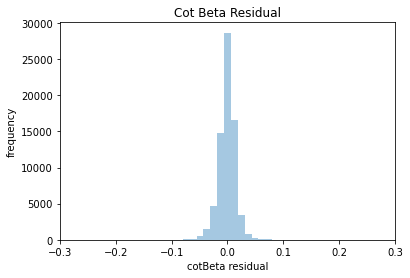

In [24]:
sns.distplot(df_true['cotBeta']-df_predict2['cotBeta'], kde=False, bins=50)
plt.xlabel('cotBeta residual')
plt.ylabel('frequency')
plt.xlim([-.3,.3])
plt.title('Cot Beta Residual')
plt.savefig('cotBeta-resolution.png')

In [25]:
df_predict2.to_csv('predictions.csv')

df_true.to_csv('trueLabels.csv')